In [1]:
import sys
import os
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from torchvision.datasets import Cityscapes
from torchvision.transforms import Compose, ToTensor,Normalize,Resize,InterpolationMode,PILToTensor

from unet.unet_model import ResNeXtUnet,Unet
from cityscapes import build_datasets
from activations import *

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.14 (you have 1.4.13). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.


In [5]:
def denormalize_img(img_tensor, mean=None, std=None):
    mean = [0.485, 0.456, 0.406]  # ImageNet mean
    std = [0.229, 0.224, 0.225]  
    # mean과 std 리스트를 텐서로 변환 후, (C, 1, 1)로 형태를 변경합니다.
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    
    # 정규화된 텐서를 원래의 범위로 복구합니다.
    img_tensor = img_tensor * std + mean
    
    return img_tensor

def get_model(model_name='resnextunet',device='cpu',checkpoint_path=None,train=False,act=None,n_classes=19):
    sup_model ={
        'unet':Unet,
        'resnextunet':ResNeXtUnet,
    }
    model = sup_model[model_name](in_channels=3,n_classes=n_classes,act=act)
    chkpt = torch.load(checkpoint_path,map_location='cpu')['model']
    model.load_state_dict(chkpt)
    if not train:
        model.eval()
    model.to(device)
    return model

def get_sample_from_dataset(idx=0,hw=(512,1024)):
    _,val_loader = build_datasets(hw=hw,batch_size=1)
    val_dataest = val_loader.dataset
    img, mask = val_dataest.__getitem__(idx)
    return img,mask.squeeze(0)


In [3]:
checkpoint_path = '/workspace/UNET/checkpoints/unet_resnext/resnext_ReLU_1_207_0.46.pth'
model = get_model('resnextunet',checkpoint_path=checkpoint_path,act=nn.ReLU(),n_classes=20)


In [3]:
checkpoint_path = '/workspace/UNET/checkpoints/unet_smu_sgd_r512/unet_SMU_1_123_0.45.pth'
model = get_model('unet',checkpoint_path=checkpoint_path,act=SMU(alpha=0.0),n_classes=20)


In [15]:
checkpoint_path = '/workspace/UNET/checkpoints/unet_cos_loss_r512/unet_ReLU_1_136_0.48.pth'
model = get_model('unet',checkpoint_path=checkpoint_path,act=nn.ReLU(),n_classes=20)


In [6]:
inp, mask = get_sample_from_dataset(idx=64,hw=(256,512))
inp.shape, mask.shape

(torch.Size([3, 256, 512]), torch.Size([256, 512]))

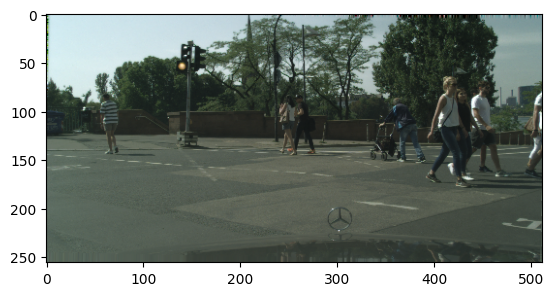

In [7]:
plt.imshow(denormalize_img(inp).permute(1,2,0).numpy())

In [9]:
def predict(model,inp,logits=False):
    with torch.no_grad():
        pred = model(inp.unsqueeze(0))
    if logits:
        return pred
    else:
        pred = pred.argmax(1).squeeze(0)
        return pred

def show_pred(model,inp):
    pred = predict(model,inp)
    plt.imshow(pred.numpy())
    plt.show()
    print(pred.unique())

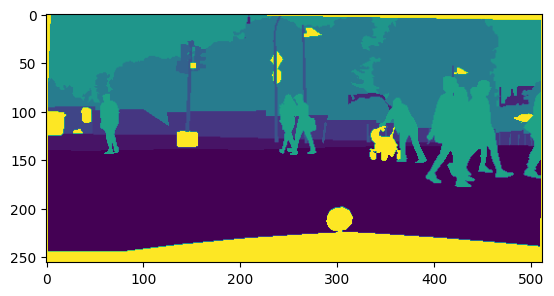

tensor([ 0,  1,  2,  3,  4,  5,  6,  8, 10, 11, 19], dtype=torch.uint8)

In [10]:
plt.imshow(mask.numpy())
plt.show()
mask.unique()

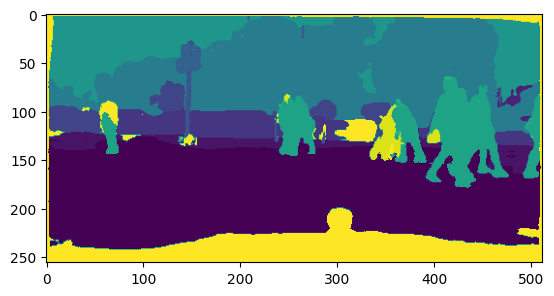

tensor([ 0,  1,  2,  3,  4,  5,  6,  8, 10, 11, 12, 13, 18, 19])


In [11]:
show_pred(model,inp)

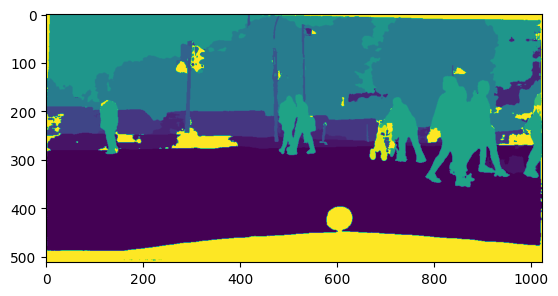

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 18, 19])


In [16]:
show_pred(model,inp)

In [9]:
import torch

def calculate_iou_vectorized(pred, target, num_classes, ignore_index=255):
    
    # Ensure long dtype for one_hot encoding
    pred = pred.long()
    target = target.long()
    
    pred = pred.view(-1)
    target = target.view(-1)
    
    # Create a mask for valid pixels (not ignore_index)
    valid_mask = target != ignore_index
    
    # Filter out ignore_index
    if ignore_index:
        pred = pred[valid_mask]
        target = target[valid_mask]
    
    # Ensure all values are within the valid range
    pred = torch.clamp(pred, 0, num_classes - 1)
    target = torch.clamp(target, 0, num_classes - 1)
    
    # One-hot encoding
    pred_one_hot = torch.nn.functional.one_hot(pred, num_classes=num_classes)
    target_one_hot = torch.nn.functional.one_hot(target, num_classes=num_classes)

    # Intersection and Union
    intersection = (pred_one_hot & target_one_hot).sum(dim=0)
    union = (pred_one_hot | target_one_hot).sum(dim=0)

    # IoU calculation
    iou = intersection.float() / union.float()
    iou[union == 0] = float('nan')  # Set IoU to NaN where union is zero

    return iou.tolist()

In [10]:
pred = predict(model,inp)
ious = calculate_iou_vectorized(pred, mask, num_classes=20, ignore_index=255)
miou = np.nanmean(ious)
miou


0.5054514463990927

In [18]:
pred = predict(model,inp)
ious = calculate_iou_vectorized(pred, mask, num_classes=20, ignore_index=19)
miou = np.nanmean(ious)
miou


0.4681942174832026

In [13]:
from torchvision.transforms import functional as TF

def lab_interpolation_mode(pred,mask,size=(512,1024),mode=TF.InterpolationMode.NEAREST_EXACT):
    pred_re = TF.resize(pred.unsqueeze(0),size,mode)[0]
    mask_re = TF.resize(mask.unsqueeze(0),size,mode)[0]
    ious = calculate_iou_vectorized(pred_re, mask_re, num_classes=20, ignore_index=None)
    miou = np.nanmean(ious)
    print(miou)

pred = predict(model,inp)
lab_interpolation_mode(pred,mask,size=(512,1024),mode=TF.InterpolationMode.NEAREST)
lab_interpolation_mode(pred,mask,size=(512,1024),mode=TF.InterpolationMode.NEAREST_EXACT)
lab_interpolation_mode(pred,mask,size=(512,1024),mode=TF.InterpolationMode.BILINEAR)
print('-'*100)
lab_interpolation_mode(pred,mask,size=(128,256),mode=TF.InterpolationMode.NEAREST)
lab_interpolation_mode(pred,mask,size=(128,256),mode=TF.InterpolationMode.NEAREST_EXACT)
lab_interpolation_mode(pred,mask,size=(128,256),mode=TF.InterpolationMode.BILINEAR)


0.5432066683258329
0.5432066683258329
0.36752729970030484
----------------------------------------------------------------------------------------------------
0.5405913697821754
0.5455175446612495
0.35860362369567156


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [27]:
from losses import DiceLoss, IOULoss

cri_dice = DiceLoss()
cri_iou = IOULoss()
ce_loss = nn.CrossEntropyLoss(ignore_index=-1)
pred = predict(model,inp,logits=True)
print(pred.shape)
cri_dice(pred,mask.unsqueeze(0)), cri_iou(pred,mask.unsqueeze(0).long()), ce_loss(pred,mask.unsqueeze(0).long())

torch.Size([1, 20, 256, 512])


(tensor(0.6226), tensor(0.6854), tensor(0.2496))

In [37]:
import torch.nn.functional as F

target_one_hot = F.one_hot(mask.unsqueeze(0).long(), num_classes=20)